In [ ]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data_dir ="/content/drive/MyDrive/Machine Learning/ProgrammingAssignment4/flower_photos"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [ ]:
database.classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
flower_name_dict={'daisy':0 ,
                  'dandelion':1,
                  'roses':2 ,
                  'sunflowers':3 ,
                  'tulips':4}

def encode_label(img_label):
    return flower_name_dict[img_label] 

In [ ]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'roses',
    3: 'sunflowers',
    4: 'tulips'
}

In [ ]:
def show_batch(dl,invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

def show_sample(image, label,invert=True):
    print("Label :" +database.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :daisy(0)


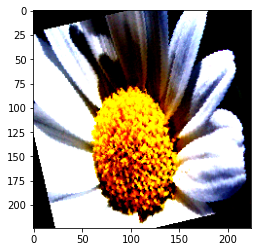

In [ ]:
show_sample(*database[1])

In [ ]:
validation_size = 500
training_size = len(database) - validation_size

In [ ]:
train_ds, val_ds_main = random_split(database,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[300, 200])
len(train_ds), len(val_ds)

(3170, 300)

In [ ]:
batch_size=32

In [ ]:
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds, batch_size)

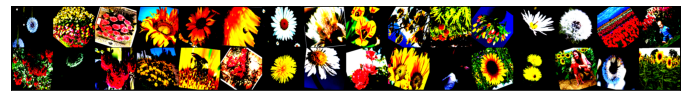

In [ ]:
show_batch(train_dl,invert=True)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModelLeNet5(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)
    

# create a complete CNN
model = FlowerModelLeNet5()
#print(model)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
 for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 224, 224])
out.shape: torch.Size([32, 5])
out[0]: tensor([ 0.0051, -0.0344, -0.0310,  0.0219, -0.0281], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
model = to_device(FlowerModelLeNet5(), device)
evaluate(model, val_dl)

{'val_loss': 1.60833740234375, 'val_acc': 0.19062499701976776}

In [ ]:
num_epochs = 10
opt_func = torch.optim.SGD
lr = 0.001

In [ ]:
%%time
try1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6085, val_loss: 1.6076, val_acc: 0.1906
Epoch [1], train_loss: 1.6078, val_loss: 1.6069, val_acc: 0.2333
Epoch [2], train_loss: 1.6072, val_loss: 1.6063, val_acc: 0.2333
Epoch [3], train_loss: 1.6066, val_loss: 1.6058, val_acc: 0.2333
Epoch [4], train_loss: 1.6064, val_loss: 1.6054, val_acc: 0.2333
Epoch [5], train_loss: 1.6054, val_loss: 1.6050, val_acc: 0.2333
Epoch [6], train_loss: 1.6053, val_loss: 1.6046, val_acc: 0.2333
Epoch [7], train_loss: 1.6042, val_loss: 1.6043, val_acc: 0.2333
Epoch [8], train_loss: 1.6041, val_loss: 1.6039, val_acc: 0.2333
Epoch [9], train_loss: 1.6036, val_loss: 1.6036, val_acc: 0.2333
CPU times: user 4min 22s, sys: 12.4 s, total: 4min 34s
Wall time: 11min 13s


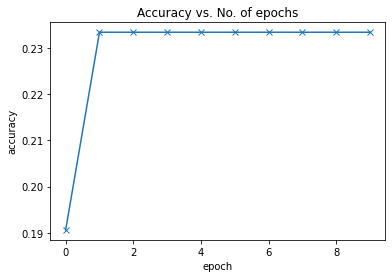

In [ ]:
def plot_accuracies(try1):
    accuracies = [x['val_acc'] for x in try1]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try1)

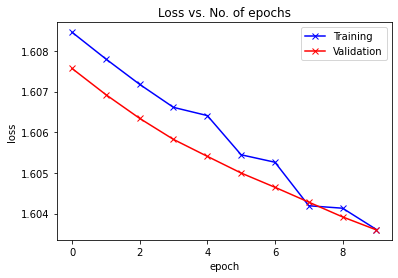

In [ ]:
def plot_losses(try1):
    train_losses = [x.get('train_loss') for x in try1]
    val_losses = [x['val_loss'] for x in try1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(try1)

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_loss': 1.610623836517334, 'val_acc': 0.1964285671710968}

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: tulips , Predicted: sunflowers


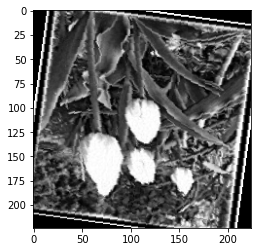

In [ ]:
img, label = test_ds[1]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelLeNet5()))

Label: dandelion , Predicted: dandelion


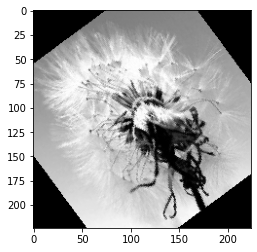

In [ ]:
img, label = test_ds[17]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelLeNet5()))

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

# 2. Transfer Learning method using Restnet50 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModelResnet50(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModelResnet50(), device)
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

{'val_loss': 1.6070187091827393, 'val_acc': 0.21875}

In [ ]:
epochs = 10
opt_func_1 = torch.optim.SGD
lr_1 = 0.001

In [ ]:
%%time
try2 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

Epoch [0], train_loss: 1.5902, val_loss: 1.5718, val_acc: 0.3792
Epoch [1], train_loss: 1.5553, val_loss: 1.5343, val_acc: 0.4427
Epoch [2], train_loss: 1.5267, val_loss: 1.5051, val_acc: 0.4573
Epoch [3], train_loss: 1.4988, val_loss: 1.4752, val_acc: 0.5896
Epoch [4], train_loss: 1.4685, val_loss: 1.4365, val_acc: 0.7125
Epoch [5], train_loss: 1.4365, val_loss: 1.4136, val_acc: 0.7104
Epoch [6], train_loss: 1.4073, val_loss: 1.3726, val_acc: 0.7875
Epoch [7], train_loss: 1.3782, val_loss: 1.3424, val_acc: 0.7969
Epoch [8], train_loss: 1.3544, val_loss: 1.3193, val_acc: 0.8000
Epoch [9], train_loss: 1.3282, val_loss: 1.2976, val_acc: 0.8031
CPU times: user 4min 34s, sys: 34 s, total: 5min 8s
Wall time: 5min 38s


In [ ]:
evaluate(model, test_dl)

{'val_loss': 1.3104948997497559, 'val_acc': 0.8035714030265808}

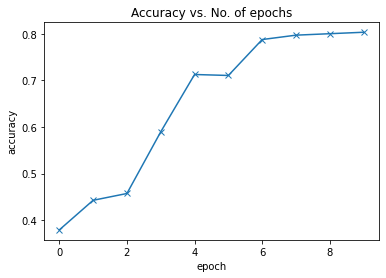

In [ ]:
def plot_accuracies(try2):
    accuracies = [x['val_acc'] for x in try2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try2)

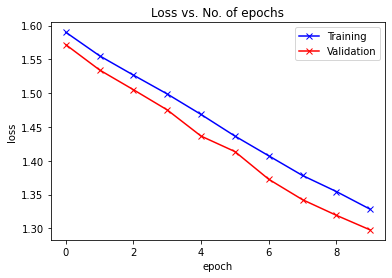

In [ ]:
def plot_losses(try2):
    train_losses = [x.get('train_loss') for x in try2]
    val_losses = [x['val_loss'] for x in try2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try2)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: tulips , Predicted: tulips


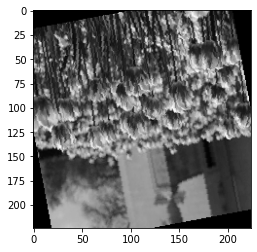

In [ ]:
img, label = test_ds[70]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

Label: daisy , Predicted: tulips


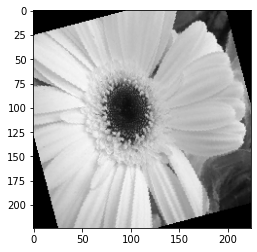

In [ ]:
img, label = test_ds[21]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

# 3. Transfer Learning method using Restnet18 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel18(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModel18(), device)
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

{'val_loss': 1.5894745588302612, 'val_acc': 0.2458333522081375}

In [ ]:
num_epochs = 10
opt_func = torch.optim.SGD
lr = 0.001

In [ ]:
%%time
try3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.5654, val_loss: 1.5528, val_acc: 0.3198
Epoch [1], train_loss: 1.5286, val_loss: 1.5111, val_acc: 0.4479
Epoch [2], train_loss: 1.4941, val_loss: 1.4839, val_acc: 0.4854
Epoch [3], train_loss: 1.4609, val_loss: 1.4466, val_acc: 0.5906
Epoch [4], train_loss: 1.4324, val_loss: 1.4134, val_acc: 0.6490
Epoch [5], train_loss: 1.4010, val_loss: 1.3833, val_acc: 0.7104
Epoch [6], train_loss: 1.3744, val_loss: 1.3551, val_acc: 0.7302
Epoch [7], train_loss: 1.3530, val_loss: 1.3305, val_acc: 0.7552
Epoch [8], train_loss: 1.3298, val_loss: 1.3036, val_acc: 0.7760
Epoch [9], train_loss: 1.3096, val_loss: 1.2841, val_acc: 0.8156
CPU times: user 3min 4s, sys: 8.49 s, total: 3min 13s
Wall time: 3min 42s


In [ ]:
evaluate(model, test_dl)

{'val_loss': 1.2882802486419678, 'val_acc': 0.7991071343421936}

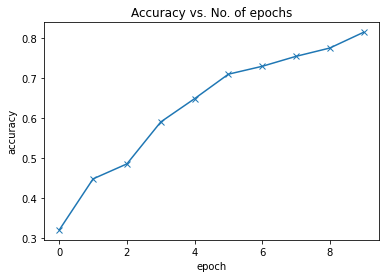

In [ ]:
def plot_accuracies(try3):
    accuracies = [x['val_acc'] for x in try3]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try3)

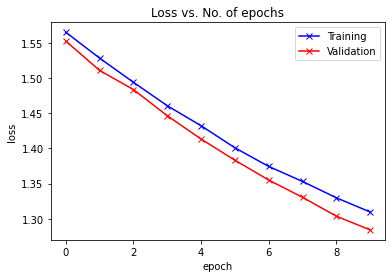

In [ ]:
def plot_losses(try3):
    train_losses = [x.get('train_loss') for x in try3]
    val_losses = [x['val_loss'] for x in try3]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try3)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: dandelion , Predicted: dandelion


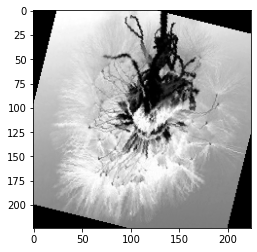

In [ ]:
img, label = test_ds[17]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))

Label: dandelion , Predicted: dandelion


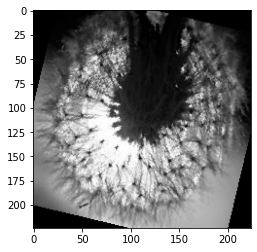

In [ ]:
img, label = test_ds[69]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))


In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

#Reflecting on the Performance Difference
From the code above, we can see that the performance we achieve with transfer learning is substantially better than the achievement we achieve with initial training (LeNet5). The validation accuracy for Basic CNN model is 0.2333 whereas the accuracy for Restnet50 is 0.8031 and for Restnet18 it is much better 0.8156. Here is the explanation -


1.   Transfer learning models outperform traditional ML models in terms of performance. The reason for this is that the models that use information (features, weights, etc.) from previously trained models already have a thorough understanding of the features. It expedites the process compared to building neural networks from scratch.
2.   Traditional machine learning models need to be trained from scratch, which is expensive computationally and needs a lot of data to work well. Transfer learning, on the other hand, helps provide better results with less data and is computationally efficient.

